In [43]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, auc
from sklearn.preprocessing import StandardScaler









In [21]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

---

In [22]:
train.isna().sum()

id           0
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [74]:
train['y'].value_counts()

y
0    659512
1     90488
Name: count, dtype: int64

In [23]:
train.dtypes

id            int64
age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y             int64
dtype: object

---

## Toy Model Using CatBoost

In [36]:
train_toy_target = train['y']
train_toy = train.drop(columns=['id', 'y'])

x_train, x_test, y_train, y_test = train_test_split(train_toy, train_toy_target, test_size=0.2, random_state=42)

In [ ]:
cat_toy = CatBoostClassifier(iterations=100,
                            depth=2,
                            learning_rate=0.1,
                            loss_function='Logloss')

In [38]:
# Assuming x_train is your DataFrame of features
categorical_features_names = x_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Make sure 'remainder__MSZoning' is in this list. It should be if its dtype is object.
print("Detected categorical features:", categorical_features_names)

Detected categorical features: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


In [39]:
cat_toy.fit(train_toy, train_toy_target, cat_features=categorical_features_names)

0:	learn: 0.6278486	total: 238ms	remaining: 23.6s
1:	learn: 0.5741329	total: 329ms	remaining: 16.1s
2:	learn: 0.5292193	total: 440ms	remaining: 14.2s
3:	learn: 0.4914171	total: 540ms	remaining: 13s
4:	learn: 0.4599659	total: 607ms	remaining: 11.5s
5:	learn: 0.4319602	total: 674ms	remaining: 10.6s
6:	learn: 0.4079631	total: 747ms	remaining: 9.92s
7:	learn: 0.3876512	total: 832ms	remaining: 9.56s
8:	learn: 0.3691457	total: 919ms	remaining: 9.29s
9:	learn: 0.3537372	total: 985ms	remaining: 8.86s
10:	learn: 0.3388699	total: 1.05s	remaining: 8.54s
11:	learn: 0.3259674	total: 1.12s	remaining: 8.24s
12:	learn: 0.3155091	total: 1.19s	remaining: 7.95s
13:	learn: 0.3043810	total: 1.27s	remaining: 7.8s
14:	learn: 0.2946152	total: 1.34s	remaining: 7.58s
15:	learn: 0.2854750	total: 1.41s	remaining: 7.38s
16:	learn: 0.2785659	total: 1.48s	remaining: 7.24s
17:	learn: 0.2713243	total: 1.55s	remaining: 7.08s
18:	learn: 0.2663896	total: 1.64s	remaining: 6.98s
19:	learn: 0.2604374	total: 1.73s	remaining:

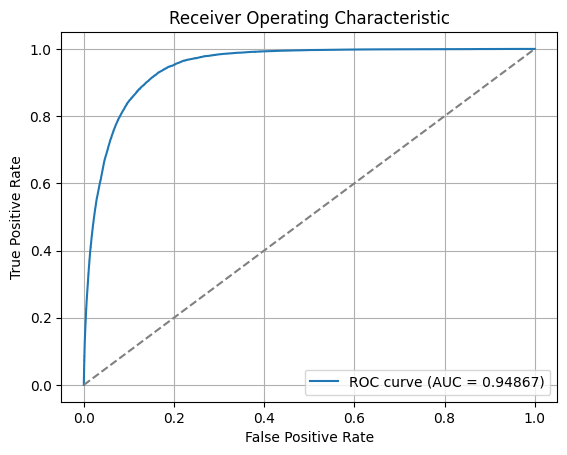

In [51]:
toy_test_proba = cat_toy.predict_proba(x_test)

fpr, tpr, thresholds = roc_curve(y_test, toy_test_proba[:,1])

roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.5f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.grid(True)
plt.show()

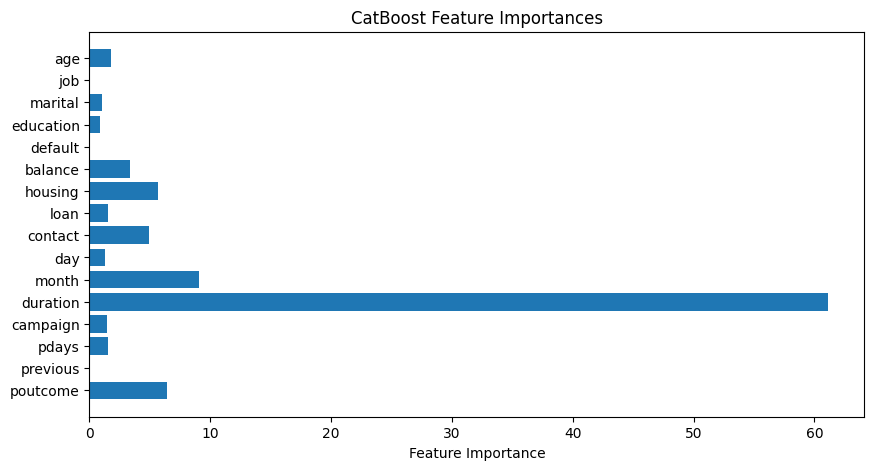

In [53]:
importances = cat_toy.get_feature_importance()

feature_names = cat_toy.feature_names_

plt.figure(figsize=(10, 5))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("CatBoost Feature Importances")
plt.gca().invert_yaxis()
plt.show()


In [ ]:
cat_cols = x_test.select_dtypes(include='object').columns.tolist()

from catboost import Pool
import shap

test_pool = Pool(x_test, label=y_test, cat_features=cat_cols, feature_names=x_test.columns.tolist())



In [68]:
shap_values = cat_toy.get_feature_importance(
    fstr_type="ShapValues",
    data=test_pool
)


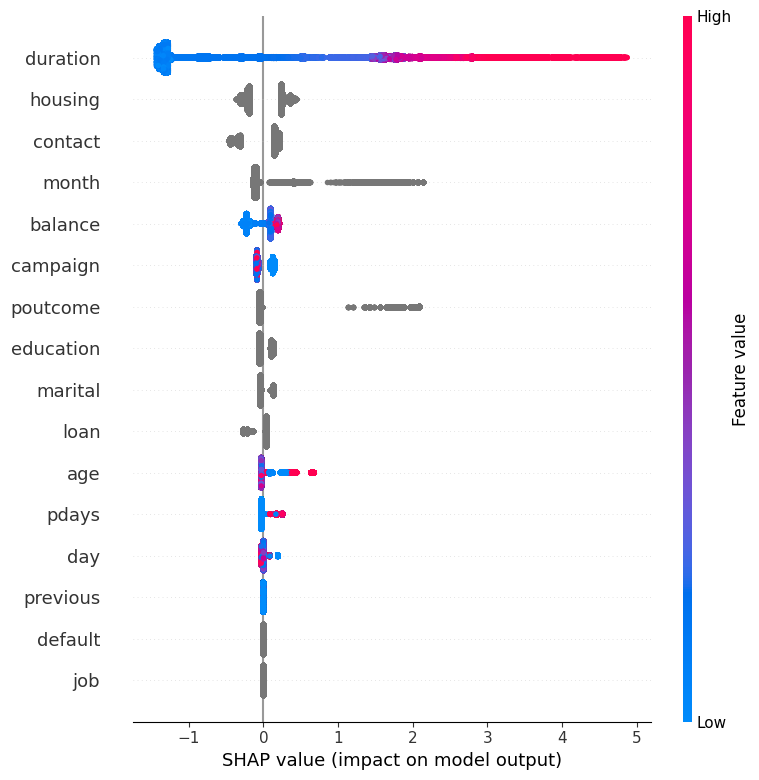

In [73]:
shap.summary_plot(
    shap_values[:, :-1],
    x_test,  # original DataFrame (with categorical features as strings)
    feature_names=cat_toy.feature_names_
)


In [80]:
tid = test['id']
tinputs = test.drop(columns=['id'])

tpreds = cat_toy.predict_proba(tinputs)


In [82]:
sub1 = pd.DataFrame({'id': test['id'], 'y': tpreds[:,1]})

In [83]:
sub1.to_csv("submissions/cat_toy.csv", index=False)

---

In [24]:
numeric_df = train.select_dtypes(include=['int64', 'float64'])

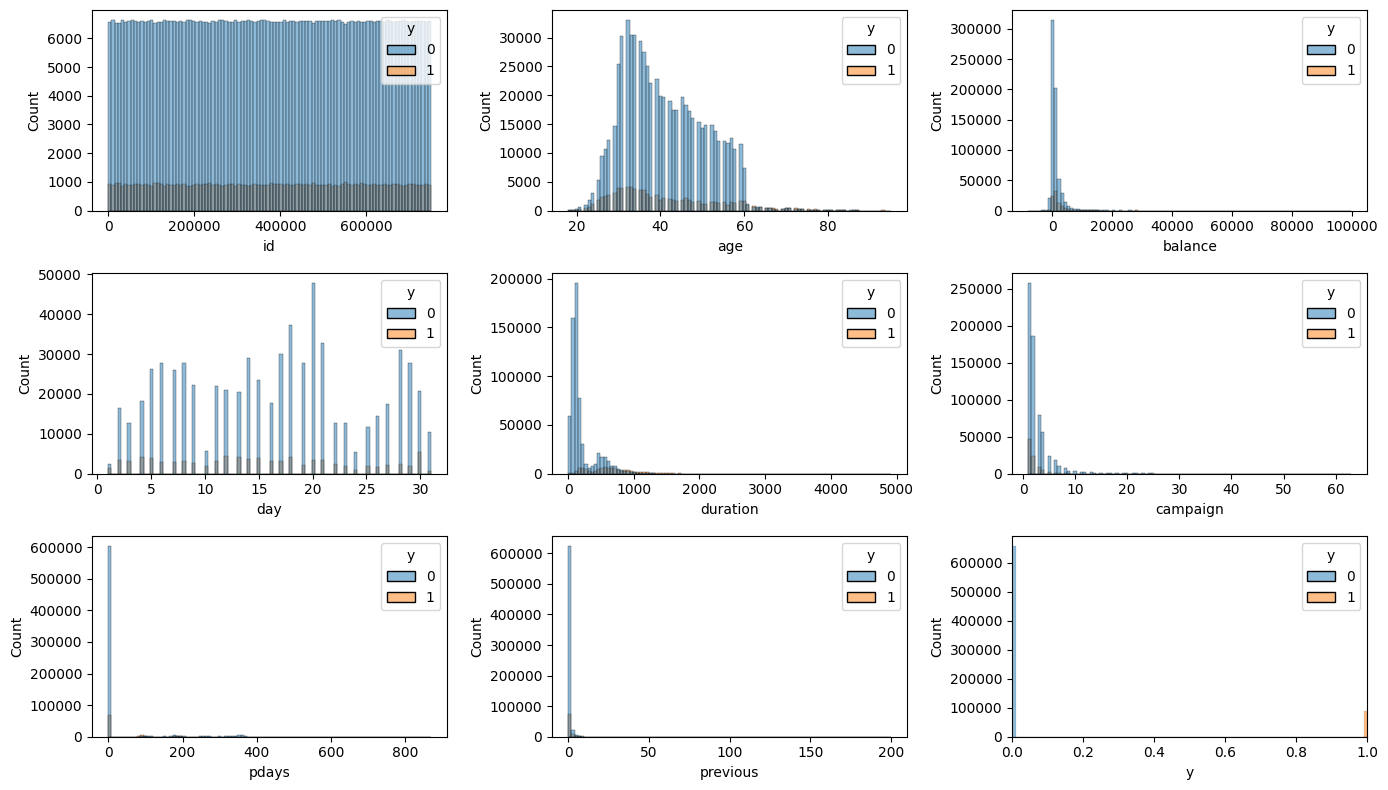

In [32]:
fig, ax = plt.subplots(3,3,figsize=(14,8))

for i, column in enumerate(numeric_df.columns):

    flat_ax = ax.flatten()

    sns.histplot(data=numeric_df, x=column, ax=flat_ax[i], hue=numeric_df['y'], bins=100)
    plt.xlim(numeric_df[column].quantile(0.02), numeric_df[column].quantile(0.98))

plt.tight_layout()
plt.show()